In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.style.use('default')
sns.set_color_codes()

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.cal'] = 'Arial'
rcParams['mathtext.it'] = 'Arial'
rcParams['mathtext.rm'] = 'Arial'

## 190520

In [2]:
data = pd.read_csv('./CalData/RM-190520-437.txt', sep='\s+', header=None)
I = data.iloc[:, 3].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
Q = data.iloc[:, 4].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
U = data.iloc[:, 5].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
V = data.iloc[:, 6].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
freq = np.linspace(8250, 3750, data.loc[:, 1].max()+1)

In [3]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, OPTICS
from astropy import constants as const

I_scale = preprocessing.MinMaxScaler().fit(I).transform(I)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max(), 0.1):
    signal_chan = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
#    signal_chan = OPTICS(min_samples=2, max_eps=i).fit(I_scale).labels_
    if len(set(signal_chan)) > 1 and 0<sum(signal_chan!=0)<len(signal_chan)/2:
        break
if sum(signal_chan!=0)<len(signal_chan)/10:
    signal_chan = -1 * (signal_chan + 1)
    signal_chan[np.sum(I, axis=1)<=10] = 0

I_scale = preprocessing.MinMaxScaler().fit(I.T).transform(I.T)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max()*2, 0.01):
    signal_time = DBSCAN(min_samples=2, eps=i).fit(np.sum(I_scale, axis=1).reshape(-1, 1)).labels_
#    signal_time = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
    if len(set(signal_time)) > 1 and 0<sum(signal_time!=0)<len(signal_time)/3 and sum((np.diff(np.where(signal_time!=0))>2)[0])<1:
        break

if len(set(signal_time)) <= 2 or len(np.where(signal_time!=0)[0]) < 5:
    signal_time = np.zeros(I.shape[1])
    signal_time[np.argmax(np.sum(I, axis=0))-0: np.argmax(np.sum(I, axis=0))+1] = 1
print(set(signal_chan), set(signal_time))

I_clean = I[signal_chan!=0][:, signal_time!=0]
Q_clean = Q[signal_chan!=0][:, signal_time!=0]
U_clean = U[signal_chan!=0][:, signal_time!=0]
V_clean = V[signal_chan!=0][:, signal_time!=0]
freq_clean = freq[signal_chan!=0]
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
rms = np.sum(I[:, signal_time==0], axis=0)[:50].std()
snr = np.sum(I_clean) / np.sqrt(I_clean.shape[1]) / rms
print('RMS: {}, SNR: {}, Time-Param: {}'.format(rms, snr, i))

{0, -1} {0, 1, -1}
RMS: 11.69941734666778, SNR: 42.42936588824435, Time-Param: 5.539999999999997


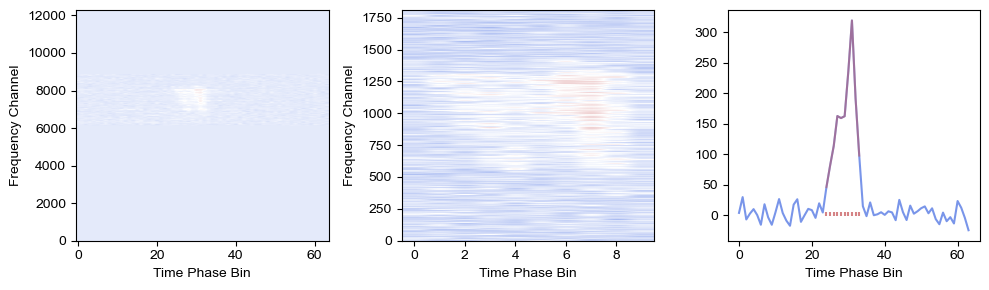

In [4]:
clist = ['royalblue', 'white', 'r']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(I, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(132)
plt.imshow(I_clean, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(133)
plt.plot(np.sum(I[signal_chan!=0], axis=0), color='royalblue', alpha=0.7)
plt.plot(np.arange(I.shape[1])[signal_time!=0], np.sum(I_clean, axis=0), color='r', alpha=0.5)
plt.vlines(np.where(signal_time!=0), -2, 5, color='r', alpha=0.7)
plt.xlabel('Time Phase Bin')

plt.tight_layout()
plt.show()

2892.8928928928926 -59.090909090909086


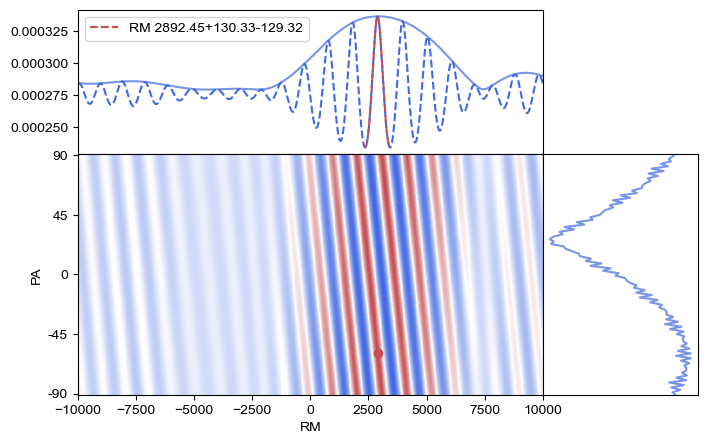

In [5]:
rm_num, rm_left, rm_right = 1000, -10000, 10000
RM = np.linspace(rm_left, rm_right, rm_num)
PAI = np.deg2rad(np.linspace(-90, 90, 100))
xx, yy = np.meshgrid(RM, PAI)

wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)
a = 1/np.sum((Qa/La-np.cos(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2 + \
           (Ua/La-np.sin(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2, axis=-1)

from scipy import interpolate
from matplotlib import gridspec

plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(8, 4)
plt.subplots_adjust(wspace=0, hspace=0)
clist = ['royalblue', 'white', 'r']
newcmp = LinearSegmentedColormap.from_list('wb', clist)

xindex = np.where(a==np.max(a))[0][0]
yindex = np.where(a==np.max(a))[1][0]
xindex_p = (xindex+50)%100
#xindex_p = xindex + 10
yindex_p = np.argmax(a[xindex_p])
corr_factor = np.abs(yindex_p - yindex)/np.sqrt((xindex_p - xindex)**2 + (yindex_p - yindex)**2)
print(xx[xindex][yindex], np.degrees(yy[xindex][yindex]))

plt.subplot(gs[0:3, 0:3])
plt.plot(RM, np.max(a, axis=0), color='royalblue', alpha=0.7)

# 局域最大值
plt.plot(RM, a[xindex], color='royalblue', ls='--')
asd = a[xindex]
intindex = (np.diff(np.sign(np.diff(asd))) > 0).nonzero()[0] + 1
intindex = intindex[np.abs(np.argmax(asd) - intindex)>5]
intindex = np.sort(intindex[np.argsort(np.abs(np.argmax(asd) - intindex))[:2]])
x = RM[intindex[0]: intindex[1]]
y = asd[intindex[0]: intindex[1]]
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.linspace(x.min(), x.max(), 500)
y_new = f(x_new)
rm_max = x_new[np.argmax(y_new)]
rm_error = -(x_new[np.argmax(y_new)] - x_new[y_new>(y_new.max()*(1-1/np.sqrt(np.e))+y_new.min()*(1/np.sqrt(np.e)))][[-1, 0]])*corr_factor
plt.plot(x_new, y_new, color='r', label='RM {:.2f}+{:.2f}{:.2f}'.format(rm_max, *rm_error), ls='--')
plt.legend()
plt.xticks([])
plt.xlim(rm_left, rm_right)

plt.subplot(gs[3:, 0:3])
pcm = plt.pcolormesh(xx, yy, a, cmap=new_cmap, shading='auto')
plt.scatter(xx[xindex][yindex], yy[xindex][yindex], color='r')
plt.xlim(rm_left, rm_right)
plt.yticks(np.deg2rad(np.linspace(-90, 90, 5)), np.linspace(-90, 90, 5).astype(np.int64))
plt.xlabel('RM')
plt.ylabel('PA')

plt.subplot(gs[3:, 3:])
plt.plot(np.max(a, axis=1), np.degrees(PAI), color='royalblue', alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.ylim(-90, 90)
plt.show()

In [6]:
wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)

def log_likelihood(par, wave, y1, y2):
    pa, rm = par
    p = 2*np.deg2rad(pa) + 2*rm*wave**2
    calul, calql = np.sin(p), np.cos(p)
    return -0.5 * np.sum((calul-y1)**2 + (calql-y2)**2)

def log_probability(par, wave, y1, y2):
    pa, rm = par
    if -90 < pa < 90 and -10000 < rm < 10000:
        lp =  0
    else:
        lp = -np.inf
    lk = log_likelihood(par, wave, y1, y2)
    if np.isnan(lk):
        return -np.inf
    return lp + lk

import emcee
from multiprocessing import Pool

ndim = 2
nwalkers = 10
p0 = np.zeros((nwalkers, ndim))
p0[:, 0] = np.random.rand(nwalkers)*10-60
p0[:, 1] = np.random.rand(nwalkers)*100+2500

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[wave, Ua/La, Qa/La])
pos = sampler.run_mcmc(p0, 3000, progress=True)
sampler.reset()
sampler.run_mcmc(pos, 1000, progress=True)

result = sampler.chain[:, :, :].reshape((-1, ndim))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1222.50it/s]


In [7]:
# from matplotlib import gridspec
# clist = ['white', 'royalblue']
# new_cmap = LinearSegmentedColormap.from_list('wb', clist)
# 
# plt.figure(figsize=(6, 5))
# plt.subplots_adjust(wspace=0, hspace=0)
# 
# print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
#                                                   result[:, 0].mean(), result[:, 0].std()))
# lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
# lowlim, uplim = np.diff(lim_value)
# samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})
# 
# g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True,
#                 label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
#                 cbar=True, cbar_kws={'label': 'Number Density'})
# print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
# 
# ax = plt.gca()
# plt.text(0.05, 0.92, 'C', weight='bold', transform=ax.transAxes)
# plt.xlim(-100, 20)
# plt.ylim(2400, 3200)
# 
# cbar_ticks = g.figure.axes[-1].get_yticks()
# _, cbar_max = g.figure.axes[-1].get_ylim()
# g.figure.axes[-1].set_yticks(cbar_ticks, ['5 %'] + ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks[1:]])
# g.set_xlabel('PA (degree)')
# g.set_ylabel('RM (rad/m$^2$)')
# 
# # plt.savefig('Figure/190520-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

RM: 2862.73022682612 +- 137.15880905755017,
PA: -54.051965153115034 +- 22.935495538682318
RM: 2881+126-158


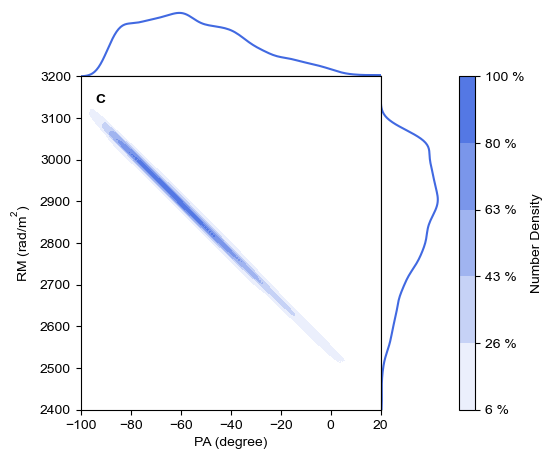

In [8]:
from matplotlib import gridspec
clist = ['white', 'royalblue']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(6, 5))
plt.subplots_adjust(wspace=0, hspace=0)
gs = gridspec.GridSpec(6, 7)

print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
                                                  result[:, 0].mean(), result[:, 0].std()))
lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
lowlim, uplim = np.diff(lim_value)
samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})

ax1 = plt.subplot(gs[0:1, 0:5])
# g = sns.histplot(data=samp_data, x='PA', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(-100, 20, 40))
g = sns.kdeplot(data=samp_data, x='PA', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, left=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlim(-100, 20)

ax1 = plt.subplot(gs[1:6, 0:5])
g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True, ax=ax1, 
                label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
                cbar=True, cbar_kws={'label': 'Number Density'})
print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
ax = plt.gca()
plt.text(0.05, 0.92, 'C', weight='bold', transform=ax.transAxes)
plt.xlim(-100, 20)
plt.ylim(2400, 3200)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
pos_joint_ax = g.get_position()
g.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 0.5, pos_joint_ax.height])
g.figure.axes[-1].set_position([.73, pos_joint_ax.y0, .07, pos_joint_ax.height])

cbar_ticks = g.figure.axes[-1].get_yticks()
_, cbar_max = g.figure.axes[-1].get_ylim()
g.figure.axes[-1].set_yticks(cbar_ticks, ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks])

g.set_xlabel('PA (degree)')
g.set_ylabel('RM (rad/m$^2$)')

ax1 = plt.subplot(gs[1:6, 5:6])
g = sns.kdeplot(data=samp_data, y='RM', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, bottom=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(2400, 3200)

# plt.savefig('Figure/190520-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

RM: 2848.305466612625, RM_Error: 147.41340414662986


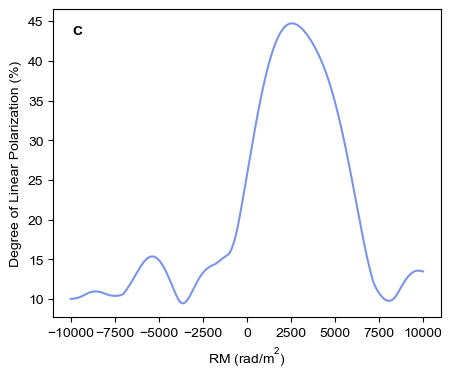

In [9]:
rm_num = 1000
Linear, rm_list = [], np.linspace(-10000, 10000, rm_num)
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
for RM in rm_list:
    PA = 2 * RM * wave**2
    Q_C = np.cos(PA)*Q_clean + np.sin(PA)*U_clean
    U_C = -np.sin(PA)*Q_clean + np.cos(PA)*U_clean
    Lsum = np.sum(np.sqrt(np.sum(Q_C, axis=0)**2 + np.sum(U_C, axis=0)**2))
    Linear = np.append(Linear, Lsum/np.sum(I_clean))
    
def rm_fit_func(x, a, b, c):
    return a * (x - b)**2 + c

rm_max_index = np.argmax(Linear)
fit_num = np.int64(len(rm_list[Linear>(np.max(Linear)+np.min(Linear))/2])/2)
x = rm_list[rm_max_index-fit_num: rm_max_index+fit_num]
y = Linear[rm_max_index-fit_num: rm_max_index+fit_num]
popt, pcov = curve_fit(rm_fit_func, x, y)
rm_max = popt[1]
rm_error = 2 * np.sqrt(-popt[2]/2/popt[0]) / snr
print('RM: {}, RM_Error: {}'.format(rm_max, rm_error))

f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.linspace(x.min(), x.max(), 500)
y_new = f(x_new)
rm_max = x_new[np.argmax(y_new)]

plt.figure(figsize=(5, 4))
plt.plot(rm_list, Linear*100, color='royalblue', alpha=0.7, label='RM {:.0f}$\\pm${:.0f}'.format(np.round(rm_max, 0), np.round(rm_error, 0)))
ax = plt.gca()
plt.text(0.05, 0.92, 'C', weight='bold', transform=ax.transAxes)
plt.xlabel('RM (rad/m$^2$)')
plt.ylabel('Degree of Linear Polarization (%)')

# plt.savefig('Figure/190520-FDF.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show() 

In [10]:
rm = rm_max
wave = const.c.value/freq/1e6
wave = wave.reshape(-1, 1)
PA = 2 * rm * wave**2
Q_C = np.cos(PA)*Q + np.sin(PA)*U
U_C = -np.sin(PA)*Q + np.cos(PA)*U
I, Q, U, V = I, Q_C, U_C, V

In [11]:
data = pd.read_csv('./CalData/RM-437.txt', sep='\s+', header=None)
I = data.iloc[:, 3].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
Q = data.iloc[:, 4].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
U = data.iloc[:, 5].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
V = data.iloc[:, 6].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
freq = np.linspace(8250, 3750, data.loc[:, 1].max()+1)

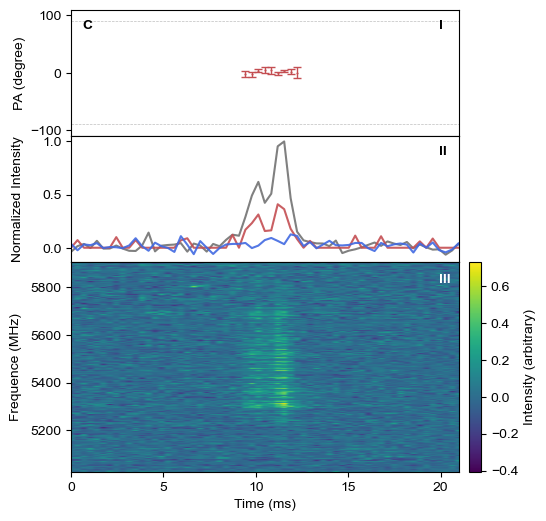

In [12]:
import matplotlib
from matplotlib import gridspec

freq_len, time_len = I.shape
freq = np.linspace(8250, 3750, freq_len)
time = np.arange(time_len) * 4.36906666666667e-05 * 8 * 1e3

Ia, Qa, Ua, Va = np.mean(I, axis=0), np.mean(Q, axis=0), np.mean(U, axis=0), np.mean(V, axis=0)
I_new = np.mean(I.reshape(freq_len//8, 8, time_len), axis=1)
normfactor = np.mean(I, axis=0).max()

plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(11, 1)
plt.subplots_adjust(hspace=0)

plt.subplot(gs[0:3, 0])

sigma_Q = Qa[:10].std()
sigma_U = Ua[:10].std()

PA = np.degrees(np.arctan2(Ua, Qa)/2)
PAE = np.degrees(np.sqrt((Qa**2 * sigma_U**2 + Ua**2 * sigma_Q**2)/(4 * (Qa**2 + Ua**2)**2)))
PAT = np.arange(len(PA)).astype(np.float64)

PA[:27] = np.nan
PA[36:] = np.nan
PAE[:27] = np.nan
PAE[36:] = np.nan

plt.errorbar(PAT, PA, PAE, color='r', fmt='.', capsize=3, lw=1, ms=1)
plt.hlines(90, 0, 60, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.hlines(-90, 0, 60, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.xticks([])
plt.xlim(0, 60)
plt.ylim(-110, 110)
plt.ylabel('PA (degree)', labelpad=3)
ax = plt.gca()
plt.text(0.03, 0.85, 'C', weight='bold', transform=ax.transAxes)
plt.text(0.95, 0.85, 'I', weight='bold', transform=ax.transAxes)

plt.subplot(gs[3:6, 0])
plt.plot(np.mean(I, axis=0)/normfactor, color='gray')

L = np.sqrt(np.mean(Q, axis=0)**2+np.mean(U, axis=0)**2)
rms = np.mean(I, axis=0)[:20].std()
L[L/rms <= 1.57] = 0
L[L/rms > 1.57] = np.sqrt(L[L/rms > 1.57]**2 - rms**2)
plt.plot(L/normfactor, color='r', alpha=0.9)
plt.plot(np.mean(V, axis=0)/normfactor, color='royalblue', alpha=0.9)
plt.xlim(0, 60)
plt.xticks([])
plt.ylabel('Normalized Intensity', labelpad=13)
ax = plt.gca()
plt.text(0.95, 0.85, 'II', weight='bold', transform=ax.transAxes)

plt.subplot(gs[6:, 0])
a = plt.imshow(I_new, aspect='auto', cmap='viridis', origin='lower')
plt.yticks(12288/8-(np.arange(3000, 9000, 200)-3750)/(8250-3750)*(freq_len/8), np.arange(3000, 9000, 200))
plt.xticks(np.arange(0, 25, 5)/1e3/8/4.36906666666667e-05, np.arange(0, 25, 5))
plt.xlabel('Time (ms)')
plt.xlim(0, 60)
plt.ylabel('Frequence (MHz)', labelpad=6)
plt.ylim(1100, 800)
ax = plt.gca()
plt.text(0.95, 0.9, 'III', weight='bold', color='white', transform=ax.transAxes)
plt.colorbar(cax=plt.axes([0.92, 0.11, 0.025, 0.35]), label='Intensity (arbitrary)')

# plt.savefig('Figure/190520-Spec.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## 190417

In [13]:
data = pd.read_csv('./CalData/RM-190417-7.txt', sep='\s+', header=None)
I = data.iloc[:, 3].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
Q = data.iloc[:, 4].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
U = data.iloc[:, 5].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
V = data.iloc[:, 6].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
freq = np.linspace(1000, 1500, data.loc[:, 1].max()+1)

In [14]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, OPTICS
from astropy import constants as const

I_scale = preprocessing.MinMaxScaler().fit(I).transform(I)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max(), 0.1):
    signal_chan = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
#    signal_chan = OPTICS(min_samples=2, max_eps=i).fit(I_scale).labels_
    if len(set(signal_chan)) > 1 and 0<sum(signal_chan!=0)<len(signal_chan)/2:
        break
if sum(signal_chan!=0)<len(signal_chan)/10:
    signal_chan = -1 * (signal_chan + 1)
    signal_chan[np.sum(I, axis=1)<=10] = 0

I_scale = preprocessing.MinMaxScaler().fit(I.T).transform(I.T)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max()*2, 0.01):
    signal_time = DBSCAN(min_samples=2, eps=i).fit(np.sum(I_scale, axis=1).reshape(-1, 1)).labels_
#    signal_time = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
    if len(set(signal_time)) > 1 and 0<sum(signal_time!=0)<len(signal_time)/3 and sum((np.diff(np.where(signal_time!=0))>2)[0])<1:
        break

if len(set(signal_time)) <= 2 or len(np.where(signal_time!=0)[0]) < 5:
    signal_time = np.zeros(I.shape[1])
    signal_time[np.argmax(np.sum(I, axis=0))-0: np.argmax(np.sum(I, axis=0))+1] = 1
print(set(signal_chan), set(signal_time))

I_clean = I[signal_chan!=0][:, signal_time!=0]
Q_clean = Q[signal_chan!=0][:, signal_time!=0]
U_clean = U[signal_chan!=0][:, signal_time!=0]
V_clean = V[signal_chan!=0][:, signal_time!=0]
freq_clean = freq[signal_chan!=0]
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
rms = np.sum(I[:, signal_time==0], axis=0)[:50].std()
snr = np.sum(I_clean) / np.sqrt(I_clean.shape[1]) / rms
print('RMS: {}, SNR: {}, Time-Param: {}'.format(rms, snr, i))

{0, -1} {0, 1, -1}
RMS: 10.70329865858121, SNR: 15.882161137914796, Time-Param: 3.919999999999998


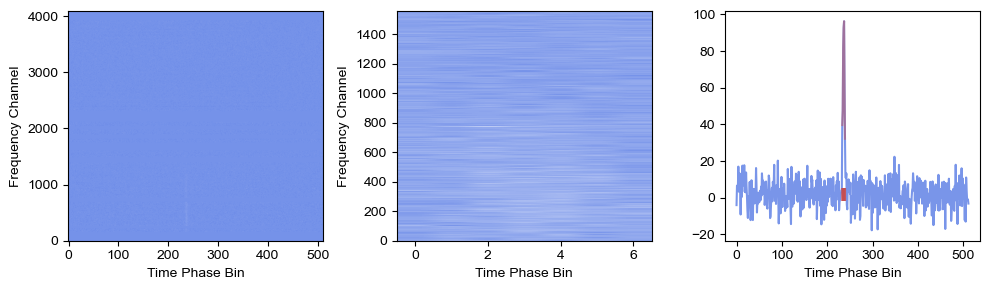

In [15]:
clist = ['royalblue', 'white', 'r']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(I, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(132)
plt.imshow(I_clean, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(133)
plt.plot(np.sum(I[signal_chan!=0], axis=0), color='royalblue', alpha=0.7)
plt.plot(np.arange(I.shape[1])[signal_time!=0], np.sum(I_clean, axis=0), color='r', alpha=0.5)
plt.vlines(np.where(signal_time!=0), -2, 5, color='r', alpha=0.7)
plt.xlabel('Time Phase Bin')

plt.tight_layout()
plt.show()

4710.710710710711 -50.0


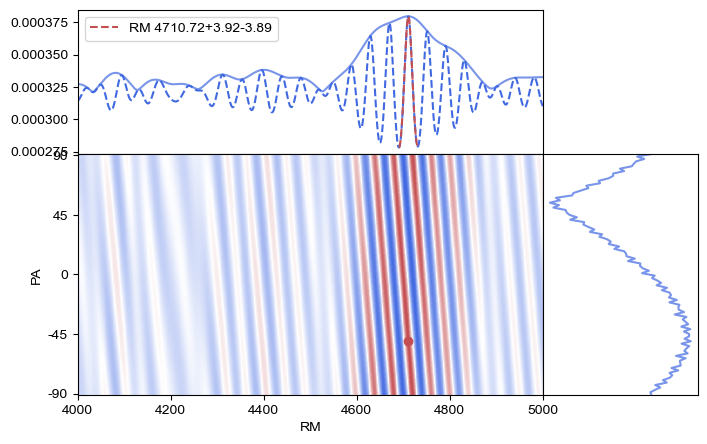

In [16]:
rm_num, rm_left, rm_right = 1000, 4000, 5000
RM = np.linspace(rm_left, rm_right, rm_num)
PAI = np.deg2rad(np.linspace(-90, 90, 100))
xx, yy = np.meshgrid(RM, PAI)

wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)
a = 1/np.sum((Qa/La-np.cos(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2 + \
           (Ua/La-np.sin(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2, axis=-1)

from scipy import interpolate
from matplotlib import gridspec

plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(8, 4)
plt.subplots_adjust(wspace=0, hspace=0)
clist = ['royalblue', 'white', 'r']
newcmp = LinearSegmentedColormap.from_list('wb', clist)

xindex = np.where(a==np.max(a))[0][0]
yindex = np.where(a==np.max(a))[1][0]
xindex_p = (xindex+50)%100
#xindex_p = xindex + 10
yindex_p = np.argmax(a[xindex_p])
corr_factor = np.abs(yindex_p - yindex)/np.sqrt((xindex_p - xindex)**2 + (yindex_p - yindex)**2)
print(xx[xindex][yindex], np.degrees(yy[xindex][yindex]))

plt.subplot(gs[0:3, 0:3])
plt.plot(RM, np.max(a, axis=0), color='royalblue', alpha=0.7)

# 局域最大值
plt.plot(RM, a[xindex], color='royalblue', ls='--')
asd = a[xindex]
intindex = (np.diff(np.sign(np.diff(asd))) > 0).nonzero()[0] + 1
intindex = intindex[np.abs(np.argmax(asd) - intindex)>5]
intindex = np.sort(intindex[np.argsort(np.abs(np.argmax(asd) - intindex))[:2]])
x = RM[intindex[0]: intindex[1]]
y = asd[intindex[0]: intindex[1]]
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.linspace(x.min(), x.max(), 500)
y_new = f(x_new)
rm_max = x_new[np.argmax(y_new)]
rm_error = -(x_new[np.argmax(y_new)] - x_new[y_new>(y_new.max()*(1-1/np.sqrt(np.e))+y_new.min()*(1/np.sqrt(np.e)))][[-1, 0]])*corr_factor
plt.plot(x_new, y_new, color='r', label='RM {:.2f}+{:.2f}{:.2f}'.format(rm_max, *rm_error), ls='--')
plt.legend()
plt.xticks([])
plt.xlim(rm_left, rm_right)

plt.subplot(gs[3:, 0:3])
pcm = plt.pcolormesh(xx, yy, a, cmap=new_cmap, shading='auto')
plt.scatter(xx[xindex][yindex], yy[xindex][yindex], color='r')
plt.xlim(rm_left, rm_right)
plt.yticks(np.deg2rad(np.linspace(-90, 90, 5)), np.linspace(-90, 90, 5).astype(np.int64))
plt.xlabel('RM')
plt.ylabel('PA')

plt.subplot(gs[3:, 3:])
plt.plot(np.max(a, axis=1), np.degrees(PAI), color='royalblue', alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.ylim(-90, 90)
plt.show()

In [17]:
wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)

def log_likelihood(par, wave, y1, y2):
    pa, rm = par
    p = 2*np.deg2rad(pa) + 2*rm*wave**2
    calul, calql = np.sin(p), np.cos(p)
    return -0.5 * np.sum((calul-y1)**2 + (calql-y2)**2)

def log_probability(par, wave, y1, y2):
    pa, rm = par
    if -90 < pa < 90 and 0 < rm < 10000:
        lp =  0
    else:
        lp = -np.inf
    lk = log_likelihood(par, wave, y1, y2)
    if np.isnan(lk):
        return -np.inf
    return lp + lk

import emcee
from multiprocessing import Pool

ndim = 2
nwalkers = 10
p0 = np.zeros((nwalkers, ndim))
p0[:, 0] = np.random.rand(nwalkers)*4-52
p0[:, 1] = np.random.rand(nwalkers)*20+4700

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[wave, Ua/La, Qa/La])
pos = sampler.run_mcmc(p0, 3000, progress=True)
sampler.reset()
sampler.run_mcmc(pos, 1000, progress=True)

result = sampler.chain[:, :, :].reshape((-1, ndim))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1242.24it/s]


In [18]:
# from matplotlib import gridspec
# clist = ['white', 'royalblue']
# new_cmap = LinearSegmentedColormap.from_list('wb', clist)
# 
# plt.figure(figsize=(6, 5))
# plt.subplots_adjust(wspace=0, hspace=0)
# gs = gridspec.GridSpec(6, 7)
# 
# print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
#                                                   result[:, 0].mean(), result[:, 0].std()))
# lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
# lowlim, uplim = np.diff(lim_value)
# samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})
# 
# g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True,
#                 label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
#                 cbar=True, cbar_kws={'label': 'Number Density'})
# print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
# ax = plt.gca()
# plt.text(0.05, 0.92, 'B', weight='bold', transform=ax.transAxes)
# plt.xlim(-100, 20)
# plt.ylim(4695, 4725)
# 
# cbar_ticks = g.figure.axes[-1].get_yticks()
# _, cbar_max = g.figure.axes[-1].get_ylim()
# g.figure.axes[-1].set_yticks(cbar_ticks, ['5 %'] + ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks[1:]])
# g.set_xlabel('PA (degree)')
# g.set_ylabel('RM (rad/m$^2$)')
# 
# # plt.savefig('Figure/190417-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

RM: 4709.461621268716 +- 4.512129907749377,
PA: -44.374478769099966 +- 19.781959842427476
RM: 4710+4-4


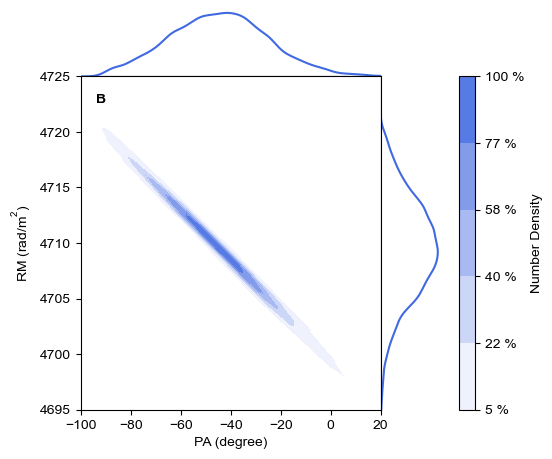

In [19]:
from matplotlib import gridspec
clist = ['white', 'royalblue']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(6, 5))
plt.subplots_adjust(wspace=0, hspace=0)
gs = gridspec.GridSpec(6, 7)

print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
                                                  result[:, 0].mean(), result[:, 0].std()))
lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
lowlim, uplim = np.diff(lim_value)
samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})

ax1 = plt.subplot(gs[0:1, 0:5])
# g = sns.histplot(data=samp_data, x='PA', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(-100, 20, 40))
g = sns.kdeplot(data=samp_data, x='PA', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, left=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlim(-100, 20)

ax1 = plt.subplot(gs[1:6, 0:5])
g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True, ax=ax1, 
                label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
                cbar=True, cbar_kws={'label': 'Number Density'})
print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
ax = plt.gca()
plt.text(0.05, 0.92, 'B', weight='bold', transform=ax.transAxes)
plt.xlim(-100, 20)
plt.ylim(4695, 4725)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
pos_joint_ax = g.get_position()
g.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 0.5, pos_joint_ax.height])
g.figure.axes[-1].set_position([.73, pos_joint_ax.y0, .07, pos_joint_ax.height])

cbar_ticks = g.figure.axes[-1].get_yticks()
_, cbar_max = g.figure.axes[-1].get_ylim()
g.figure.axes[-1].set_yticks(cbar_ticks, ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks])

g.set_xlabel('PA (degree)')
g.set_ylabel('RM (rad/m$^2$)')

ax1 = plt.subplot(gs[1:6, 5:6])
g = sns.kdeplot(data=samp_data, y='RM', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, bottom=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(4695, 4725)

# plt.savefig('Figure/190417-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

RM: 4710.550992386453, RM_Error: 15.528548187521123


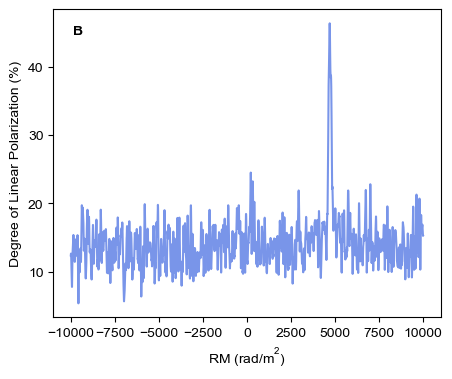

In [20]:
rm_num = 10000
Linear, rm_list = [], np.linspace(-10000, 10000, rm_num)
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
for RM in rm_list:
    PA = 2 * RM * wave**2
    Q_C = np.cos(PA)*Q_clean + np.sin(PA)*U_clean
    U_C = -np.sin(PA)*Q_clean + np.cos(PA)*U_clean
    Lsum = np.sum(np.sqrt(np.sum(Q_C, axis=0)**2 + np.sum(U_C, axis=0)**2))
    Linear = np.append(Linear, Lsum/np.sum(I_clean))
    
def rm_fit_func(x, a, b, c):
    return a * (x - b)**2 + c

rm_max_index = np.argmax(Linear)
fit_num = np.int64(len(rm_list[Linear>(np.max(Linear)+np.min(Linear))/2])/2)
x = rm_list[rm_max_index-fit_num: rm_max_index+fit_num]
y = Linear[rm_max_index-fit_num: rm_max_index+fit_num]
popt, pcov = curve_fit(rm_fit_func, x, y)
rm_max = popt[1]
rm_error = 2 * np.sqrt(-popt[2]/2/popt[0]) / snr
print('RM: {}, RM_Error: {}'.format(rm_max, rm_error))

plt.figure(figsize=(5, 4))
plt.plot(rm_list, Linear*100, color='royalblue', alpha=0.7, label='RM {:.0f}$\\pm${:.0f}'.format(np.round(rm_max, 0), np.round(rm_error, 0)))
ax = plt.gca()
plt.text(0.05, 0.92, 'B', weight='bold', transform=ax.transAxes)
plt.xlabel('RM (rad/m$^2$)')
plt.ylabel('Degree of Linear Polarization (%)')

# plt.savefig('Figure/190417-FDF.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
rm = rm_max
wave = const.c.value/freq/1e6
wave = wave.reshape(-1, 1)
PA = 2 * rm * wave**2
Q_C = np.cos(PA)*Q + np.sin(PA)*U
U_C = -np.sin(PA)*Q + np.cos(PA)*U
I, Q, U, V = I, Q_C, U_C, V

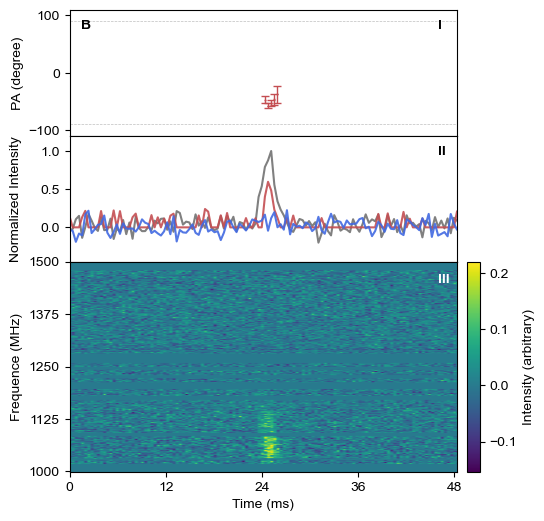

In [22]:
import matplotlib
from matplotlib import gridspec

pol3 = np.stack((I, Q, U, V))
max_index = np.argmax(np.sum(pol3[0], axis=0))
I, Q, U, V = pol3[:, :, max_index-64: max_index+64]

freq_len, time_len = I.shape
I_new = np.mean(I.reshape(freq_len//16, 16, time_len), axis=1)
normfactor = np.mean(I, axis=0).max()

Ia, Qa, Ua, Va = np.mean(I, axis=0), np.mean(Q, axis=0), np.mean(U, axis=0), np.mean(V, axis=0)

plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(11, 1)
plt.subplots_adjust(hspace=0)

plt.subplot(gs[0:3, 0])

sigma_Q = Qa[:10].std()
sigma_U = Ua[:10].std()

PA = np.degrees(np.arctan2(Ua, Qa)/2)
PAE = np.degrees(np.sqrt((Qa**2 * sigma_U**2 + Ua**2 * sigma_Q**2)/(4 * (Qa**2 + Ua**2)**2)))
PAT = np.arange(len(PA)).astype(np.float64)

PA[:62] = np.nan
PA[67:] = np.nan
PAE[:62] = np.nan
PAE[67:] = np.nan

plt.errorbar(PAT, PA, PAE, color='r', fmt='.', capsize=3, lw=1, ms=1)
plt.hlines(90, 0, 123, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.hlines(-90, 0, 123, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.xticks([])
plt.xlim(0, 123)
plt.ylim(-110, 110)
plt.ylabel('PA (degree)', labelpad=3)
ax = plt.gca()
plt.text(0.03, 0.85, 'B', weight='bold', transform=ax.transAxes)
plt.text(0.95, 0.85, 'I', weight='bold', transform=ax.transAxes)

plt.subplot(gs[3:6, 0])
L = np.sqrt(np.mean(Q, axis=0)**2+np.mean(U, axis=0)**2)
rms = np.mean(I, axis=0)[:20].std()
L[L/rms <= 1.57] = 0
L[L/rms > 1.57] = np.sqrt(L[L/rms > 1.57]**2 - rms**2)

plt.plot(np.mean(I, axis=0)/normfactor, color='gray')
plt.plot(L/normfactor, color='r', alpha=0.9)
plt.plot(np.mean(V, axis=0)/normfactor, color='royalblue', alpha=0.9)
plt.ylim(-0.45, 1.2)
plt.xlim(0, 123)
plt.xticks([])
plt.ylabel('Normalized Intensity', labelpad=13)
ax = plt.gca()
plt.text(0.95, 0.85, 'II', weight='bold', transform=ax.transAxes)

plt.subplot(gs[6:, 0])
plt.imshow(I_new, aspect='auto', cmap='viridis', origin='lower')
plt.yticks(np.linspace(0, 256, 5).astype(np.int64), np.linspace(1000, 1500, 5).astype(np.int64))
plt.xticks(np.linspace(0, 48, 5)*1e3/4/98.304, np.linspace(0, 48, 5).astype(np.int64))
plt.xlim(0, 123)
plt.xlabel('Time (ms)')
plt.ylabel('Frequence (MHz)')
ax = plt.gca()
plt.text(0.95, 0.9, 'III', weight='bold', color='white', transform=ax.transAxes)
plt.colorbar(cax=plt.axes([0.92, 0.11, 0.025, 0.35]), label='Intensity (arbitrary)')

# plt.savefig('Figure/190417-Spec.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## 201124

In [23]:
data = pd.read_csv('./CalData/RM-201124-26.txt', sep='\s+', header=None)
I = data.iloc[:, 3].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
Q = data.iloc[:, 4].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
U = data.iloc[:, 5].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
V = data.iloc[:, 6].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
freq = np.linspace(920, 720, data.loc[:, 1].max()+2)[:data.loc[:, 1].max()+1]

In [24]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, OPTICS
from astropy import constants as const

I_scale = preprocessing.MinMaxScaler().fit(I).transform(I)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max(), 0.1):
    signal_chan = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
#    signal_chan = OPTICS(min_samples=2, max_eps=i).fit(I_scale).labels_
    if len(set(signal_chan)) > 1 and 0<sum(signal_chan!=0)<len(signal_chan)/2:
        break
if sum(signal_chan!=0)<len(signal_chan)/10:
    signal_chan = -1 * (signal_chan + 1)
    signal_chan[np.sum(I, axis=1)<=10] = 0

I_scale = preprocessing.MinMaxScaler().fit(I.T).transform(I.T)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max()*2, 0.01):
    signal_time = DBSCAN(min_samples=2, eps=i).fit(np.sum(I_scale, axis=1).reshape(-1, 1)).labels_
#    signal_time = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
    if len(set(signal_time)) > 1 and 0<sum(signal_time!=0)<len(signal_time)/3 and sum((np.diff(np.where(signal_time!=0))>2)[0])<1:
        break

if len(set(signal_time)) <= 2 or len(np.where(signal_time!=0)[0]) < 5:
    signal_time = np.zeros(I.shape[1])
    signal_time[np.argmax(np.sum(I, axis=0))-0: np.argmax(np.sum(I, axis=0))+1] = 1
print(set(signal_chan), set(signal_time))

I_clean = I[signal_chan!=0][:, signal_time!=0]
Q_clean = Q[signal_chan!=0][:, signal_time!=0]
U_clean = U[signal_chan!=0][:, signal_time!=0]
V_clean = V[signal_chan!=0][:, signal_time!=0]
freq_clean = freq[signal_chan!=0]
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
rms = np.sum(I[:, signal_time==0], axis=0)[:50].std()
snr = np.sum(I_clean) / np.sqrt(I_clean.shape[1]) / rms
print('RMS: {}, SNR: {}, Time-Param: {}'.format(rms, snr, i))

{0, -1} {0, 1, 2, 3, 4}
RMS: 1.2850018091691922, SNR: 57.953079606103806, Time-Param: 5.839999999999997


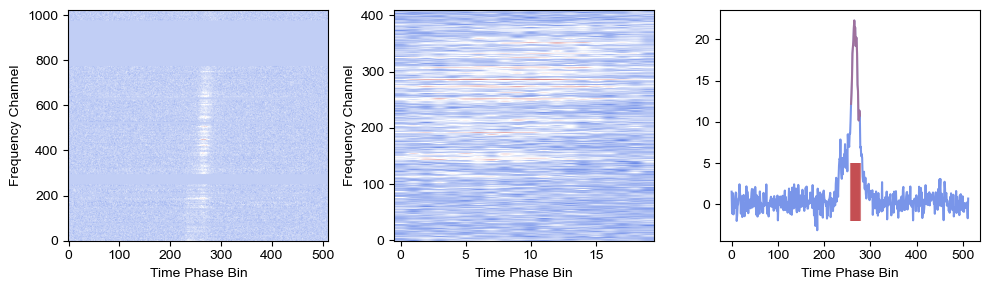

In [25]:
clist = ['royalblue', 'white', 'r']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(I, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(132)
plt.imshow(I_clean, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(133)
plt.plot(np.sum(I[signal_chan!=0], axis=0), color='royalblue', alpha=0.7)
plt.plot(np.arange(I.shape[1])[signal_time!=0], np.sum(I_clean, axis=0), color='r', alpha=0.5)
plt.vlines(np.where(signal_time!=0), -2, 5, color='r', alpha=0.7)
plt.xlabel('Time Phase Bin')

plt.tight_layout()
plt.show()

-620.6206206206206 -68.18181818181819


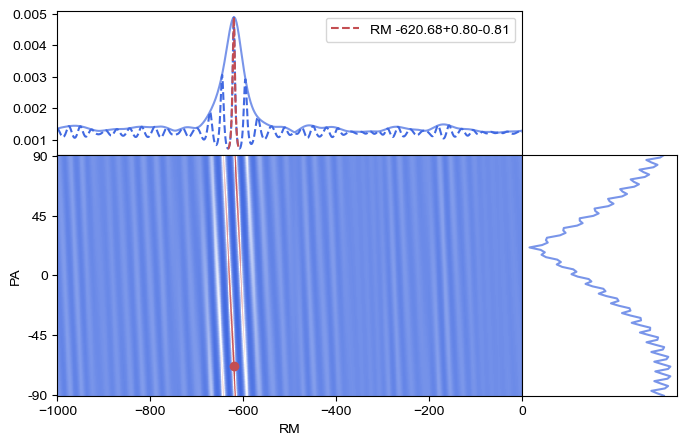

In [26]:
rm_num, rm_left, rm_right = 1000, -1000, 0
RM = np.linspace(rm_left, rm_right, rm_num)
PAI = np.deg2rad(np.linspace(-90, 90, 100))
xx, yy = np.meshgrid(RM, PAI)

wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)
a = 1/np.sum((Qa/La-np.cos(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2 + \
           (Ua/La-np.sin(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2, axis=-1)

from scipy import interpolate
from matplotlib import gridspec

plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(8, 4)
plt.subplots_adjust(wspace=0, hspace=0)
clist = ['royalblue', 'white', 'r']
newcmp = LinearSegmentedColormap.from_list('wb', clist)

xindex = np.where(a==np.max(a))[0][0]
yindex = np.where(a==np.max(a))[1][0]
xindex_p = (xindex+50)%100
#xindex_p = xindex + 10
yindex_p = np.argmax(a[xindex_p])
corr_factor = np.abs(yindex_p - yindex)/np.sqrt((xindex_p - xindex)**2 + (yindex_p - yindex)**2)
print(xx[xindex][yindex], np.degrees(yy[xindex][yindex]))

plt.subplot(gs[0:3, 0:3])
plt.plot(RM, np.max(a, axis=0), color='royalblue', alpha=0.7)

# 局域最大值
plt.plot(RM, a[xindex], color='royalblue', ls='--')
asd = a[xindex]
intindex = (np.diff(np.sign(np.diff(asd))) > 0).nonzero()[0] + 1
intindex = intindex[np.abs(np.argmax(asd) - intindex)>5]
intindex = np.sort(intindex[np.argsort(np.abs(np.argmax(asd) - intindex))[:2]])
x = RM[intindex[0]: intindex[1]]
y = asd[intindex[0]: intindex[1]]
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.linspace(x.min(), x.max(), 500)
y_new = f(x_new)
rm_max = x_new[np.argmax(y_new)]
rm_error = -(x_new[np.argmax(y_new)] - x_new[y_new>(y_new.max()*(1-1/np.sqrt(np.e))+y_new.min()*(1/np.sqrt(np.e)))][[-1, 0]])*corr_factor
plt.plot(x_new, y_new, color='r', label='RM {:.2f}+{:.2f}{:.2f}'.format(rm_max, *rm_error), ls='--')
plt.legend()
plt.xticks([])
plt.xlim(rm_left, rm_right)

plt.subplot(gs[3:, 0:3])
pcm = plt.pcolormesh(xx, yy, a, cmap=new_cmap, shading='auto')
plt.scatter(xx[xindex][yindex], yy[xindex][yindex], color='r')
plt.xlim(rm_left, rm_right)
plt.yticks(np.deg2rad(np.linspace(-90, 90, 5)), np.linspace(-90, 90, 5).astype(np.int64))
plt.xlabel('RM')
plt.ylabel('PA')

plt.subplot(gs[3:, 3:])
plt.plot(np.max(a, axis=1), np.degrees(PAI), color='royalblue', alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.ylim(-90, 90)
plt.show()

In [27]:
wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)

def log_likelihood(par, wave, y1, y2):
    pa, rm = par
    p = 2*np.deg2rad(pa) + 2*rm*wave**2
    calul, calql = np.sin(p), np.cos(p)
    return -0.5 * np.sum((calul-y1)**2 + (calql-y2)**2)

def log_probability(par, wave, y1, y2):
    pa, rm = par
    if -90 < pa < 90 and -10000 < rm < 10000:
        lp =  0
    else:
        lp = -np.inf
    lk = log_likelihood(par, wave, y1, y2)
    if np.isnan(lk):
        return -np.inf
    return lp + lk

import emcee
from multiprocessing import Pool

ndim = 2
nwalkers = 10
p0 = np.zeros((nwalkers, ndim))
p0[:, 0] = np.random.rand(nwalkers)*10-70
p0[:, 1] = np.random.rand(nwalkers)*10-625

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[wave, Ua/La, Qa/La])
pos = sampler.run_mcmc(p0, 3000, progress=True)
sampler.reset()
sampler.run_mcmc(pos, 1000, progress=True)

result = sampler.chain[:, :, :].reshape((-1, ndim))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1706.49it/s]


In [28]:
# from matplotlib import gridspec
# clist = ['white', 'royalblue']
# new_cmap = LinearSegmentedColormap.from_list('wb', clist)
# 
# plt.figure(figsize=(6, 5))
# plt.subplots_adjust(wspace=0, hspace=0)
# gs = gridspec.GridSpec(6, 7)
# 
# print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
#                                                   result[:, 0].mean(), result[:, 0].std()))
# lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
# lowlim, uplim = np.diff(lim_value)
# samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})
# 
# g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True, 
#                 label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
#                 cbar=True, cbar_kws={'label': 'Number Density'})
# print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
# ax = plt.gca()
# plt.text(0.05, 0.92, 'D', weight='bold', transform=ax.transAxes)
# plt.xlim(-100, -30)
# plt.ylim(-626, -616)
# 
# cbar_ticks = g.figure.axes[-1].get_yticks()
# _, cbar_max = g.figure.axes[-1].get_ylim()
# g.figure.axes[-1].set_yticks(cbar_ticks, ['5 %'] + ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks[1:]])
# g.set_xlabel('PA (degree)')
# g.set_ylabel('RM (rad/m$^2$)')
# 
# # plt.savefig('Figure/201124-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

RM: -620.691232575039 +- 1.718098343917727,
PA: -68.3027831015293 +- 12.403791918557825
RM: -621+2-2


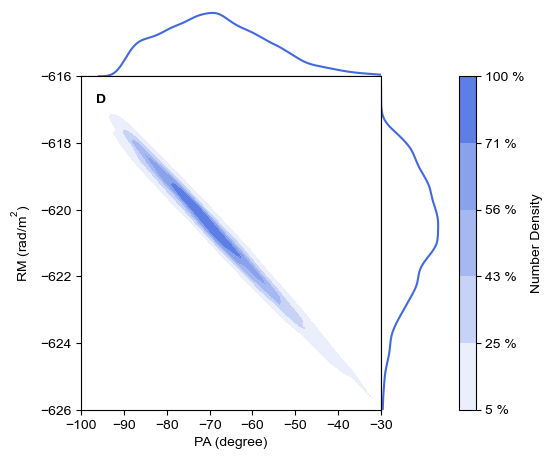

In [29]:
from matplotlib import gridspec
clist = ['white', 'royalblue']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(6, 5))
plt.subplots_adjust(wspace=0, hspace=0)
gs = gridspec.GridSpec(6, 7)

print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
                                                  result[:, 0].mean(), result[:, 0].std()))
lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
lowlim, uplim = np.diff(lim_value)
samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})

ax1 = plt.subplot(gs[0:1, 0:5])
# g = sns.histplot(data=samp_data, x='PA', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(-100, 20, 40))
g = sns.kdeplot(data=samp_data, x='PA', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, left=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlim(-100, -30)

ax1 = plt.subplot(gs[1:6, 0:5])
g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True, ax=ax1, 
                label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
                cbar=True, cbar_kws={'label': 'Number Density'})
print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
ax = plt.gca()
plt.text(0.05, 0.92, 'D', weight='bold', transform=ax.transAxes)
plt.xlim(-100, -30)
plt.ylim(-626, -616)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
pos_joint_ax = g.get_position()
g.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 0.5, pos_joint_ax.height])
g.figure.axes[-1].set_position([.73, pos_joint_ax.y0, .07, pos_joint_ax.height])

cbar_ticks = g.figure.axes[-1].get_yticks()
_, cbar_max = g.figure.axes[-1].get_ylim()
g.figure.axes[-1].set_yticks(cbar_ticks, ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks])

g.set_xlabel('PA (degree)')
g.set_ylabel('RM (rad/m$^2$)')

ax1 = plt.subplot(gs[1:6, 5:6])
g = sns.kdeplot(data=samp_data, y='RM', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, bottom=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(-626, -616)

# plt.savefig('Figure/201124-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

RM: -622.7626278906888, RM_Error: 1.7438668654530998


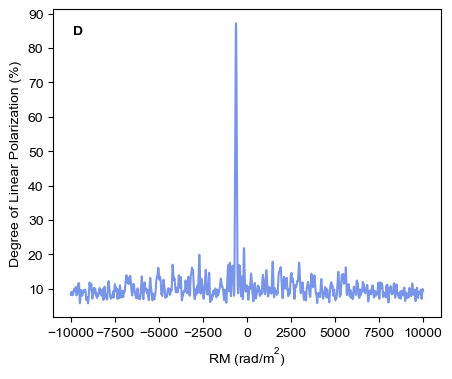

In [30]:
rm_num = 10000
Linear, rm_list = [], np.linspace(-10000, 10000, rm_num)
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
for RM in rm_list:
    PA = 2 * RM * wave**2
    Q_C = np.cos(PA)*Q_clean + np.sin(PA)*U_clean
    U_C = -np.sin(PA)*Q_clean + np.cos(PA)*U_clean
    Lsum = np.sum(np.sqrt(np.sum(Q_C, axis=0)**2 + np.sum(U_C, axis=0)**2))
    Linear = np.append(Linear, Lsum/np.sum(I_clean))
    
def rm_fit_func(x, a, b, c):
    return a * (x - b)**2 + c

rm_max_index = np.argmax(Linear)
fit_num = np.int64(len(rm_list[Linear>(np.max(Linear)+np.min(Linear))/2])/2)
x = rm_list[rm_max_index-fit_num: rm_max_index+fit_num]
y = Linear[rm_max_index-fit_num: rm_max_index+fit_num]
popt, pcov = curve_fit(rm_fit_func, x, y)
rm_max = popt[1]
rm_error = 2 * np.sqrt(-popt[2]/2/popt[0]) / snr
print('RM: {}, RM_Error: {}'.format(rm_max, rm_error))

plt.figure(figsize=(5, 4))
plt.plot(rm_list, Linear*100, color='royalblue', alpha=0.7, label='RM {:.0f}$\\pm${:.0f}'.format(np.round(rm_max, 0), np.round(rm_error, 0)))
plt.xlabel('RM (rad/m$^2$)')
plt.ylabel('Degree of Linear Polarization (%)')
ax = plt.gca()
plt.text(0.05, 0.92, 'D', weight='bold', transform=ax.transAxes)

# plt.savefig('Figure/201124-FDF.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
rm = rm_max
wave = const.c.value/freq/1e6
wave = wave.reshape(-1, 1)
PA = 2 * rm * wave**2
Q_C = np.cos(PA)*Q + np.sin(PA)*U
U_C = -np.sin(PA)*Q + np.cos(PA)*U
I, Q, U, V = I, Q_C, U_C, V

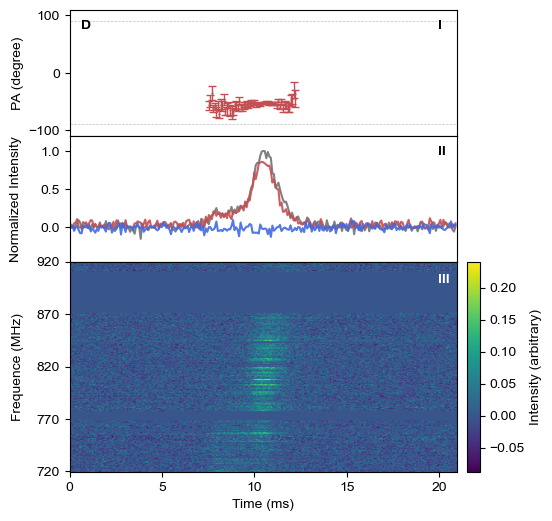

In [32]:
import matplotlib
from matplotlib import gridspec

pol3 = np.stack((I, Q, U, V))
max_index = np.argmax(np.sum(pol3[0], axis=0))
I, Q, U, V = pol3[:, :, max_index-128: max_index+128]

freq_len, time_len = I.shape
I_new = np.mean(I.reshape(freq_len//4, 4, time_len), axis=1)
normfactor = np.mean(I, axis=0).max()

Ia, Qa, Ua, Va = np.mean(I, axis=0), np.mean(Q, axis=0), np.mean(U, axis=0), np.mean(V, axis=0)

plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(11, 1)
plt.subplots_adjust(hspace=0)

plt.subplot(gs[0:3, 0])

sigma_Q = Qa[:10].std()
sigma_U = Ua[:10].std()

PA = np.degrees(np.arctan2(Ua, Qa)/2)
PAE = np.degrees(np.sqrt((Qa**2 * sigma_U**2 + Ua**2 * sigma_Q**2)/(4 * (Qa**2 + Ua**2)**2)))
PAT = np.arange(len(PA)).astype(np.float64)

PA[:92] = np.nan
PA[150:] = np.nan
PAE[:92] = np.nan
PAE[150:] = np.nan

plt.errorbar(PAT, PA, PAE, color='r', fmt='.', capsize=3, lw=1, ms=1)
plt.hlines(90, 0, 256, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.hlines(-90, 0, 256, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.xticks([])
plt.xlim(0, 256)
plt.ylim(-110, 110)
plt.ylabel('PA (degree)', labelpad=3)
ax = plt.gca()
plt.text(0.03, 0.85, 'D', weight='bold', transform=ax.transAxes)
plt.text(0.95, 0.85, 'I', weight='bold', transform=ax.transAxes)

plt.subplot(gs[3:6, 0])
L = np.sqrt(np.mean(Q, axis=0)**2+np.mean(U, axis=0)**2)
rms = np.mean(I, axis=0)[:20].std()
L[L/rms <= 1.57] = 0
L[L/rms > 1.57] = np.sqrt(L[L/rms > 1.57]**2 - rms**2)

plt.plot(np.mean(I, axis=0)/normfactor, color='gray')
plt.plot(L/normfactor, color='r', alpha=0.9)
plt.plot(np.mean(V, axis=0)/normfactor, color='royalblue', alpha=0.9)
plt.ylim(-0.45, 1.2)
plt.xlim(0, 256)
plt.xticks([])
plt.ylabel('Normalized Intensity', labelpad=13)
ax = plt.gca()
plt.text(0.95, 0.85, 'II', weight='bold', transform=ax.transAxes)

plt.subplot(gs[6:, 0])
plt.imshow(I_new, aspect='auto', cmap='viridis', origin='lower')
plt.yticks(np.linspace(0, 256, 5).astype(np.int64), np.linspace(720, 920, 5).astype(np.int64))
plt.xticks(np.linspace(0, 25, 6)*1e3/81.92, np.linspace(0, 25, 6).astype(np.int64))
plt.xlim(0, 256)
plt.xlabel('Time (ms)')
plt.ylabel('Frequence (MHz)', labelpad=9)
ax = plt.gca()
plt.text(0.95, 0.9, 'III', weight='bold', color='white', transform=ax.transAxes)
plt.colorbar(cax=plt.axes([0.92, 0.11, 0.025, 0.35]), label='Intensity (arbitrary)')

# plt.savefig('Figure/201124-Spec.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## 190303

In [33]:
data = pd.read_csv('./CalData/RM-190303-1.txt', sep='\s+', header=None)
I = data.iloc[:, 3].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
Q = data.iloc[:, 4].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
U = data.iloc[:, 5].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
V = data.iloc[:, 6].values.reshape(data.loc[:, 1].max()+1, data.loc[:, 2].max()+1)
freq = np.linspace(1000, 1500, data.loc[:, 1].max()+1)

In [34]:
from sklearn import preprocessing
from sklearn.cluster import DBSCAN, OPTICS
from astropy import constants as const

I_scale = preprocessing.MinMaxScaler().fit(I).transform(I)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max(), 0.1):
    signal_chan = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
#    signal_chan = OPTICS(min_samples=2, max_eps=i).fit(I_scale).labels_
    if len(set(signal_chan)) > 1 and 0<sum(signal_chan!=0)<len(signal_chan)/2:
        break
if sum(signal_chan!=0)<len(signal_chan)/10:
    signal_chan = -1 * (signal_chan + 1)
    signal_chan[np.sum(I, axis=1)<=10] = 0

I_scale = preprocessing.MinMaxScaler().fit(I.T).transform(I.T)
for i in np.arange(0.1, np.linalg.norm(I_scale, axis=1).max()*2, 0.01):
    signal_time = DBSCAN(min_samples=2, eps=i).fit(np.sum(I_scale, axis=1).reshape(-1, 1)).labels_
#    signal_time = DBSCAN(min_samples=2, eps=i).fit(I_scale).labels_
    if len(set(signal_time)) > 1 and 0<sum(signal_time!=0)<len(signal_time)/3 and sum((np.diff(np.where(signal_time!=0))>2)[0])<1:
        break

if len(set(signal_time)) <= 2 or len(np.where(signal_time!=0)[0]) < 5:
    signal_time = np.zeros(I.shape[1])
    signal_time[np.argmax(np.sum(I, axis=0))-2: np.argmax(np.sum(I, axis=0))+2] = 1
print(set(signal_chan), set(signal_time))

I_clean = I[signal_chan!=0][:, signal_time!=0]
Q_clean = Q[signal_chan!=0][:, signal_time!=0]
U_clean = U[signal_chan!=0][:, signal_time!=0]
V_clean = V[signal_chan!=0][:, signal_time!=0]
freq_clean = freq[signal_chan!=0]
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
rms = np.sum(I[:, signal_time==0], axis=0)[:50].std()
snr = np.sum(I_clean) / np.sqrt(I_clean.shape[1]) / rms
print('RMS: {}, SNR: {}, Time-Param: {}'.format(rms, snr, i))

{0, -1} {0.0, 1.0}
RMS: 9.71940737566431, SNR: 6.778018036876173, Time-Param: 2.469999999999999


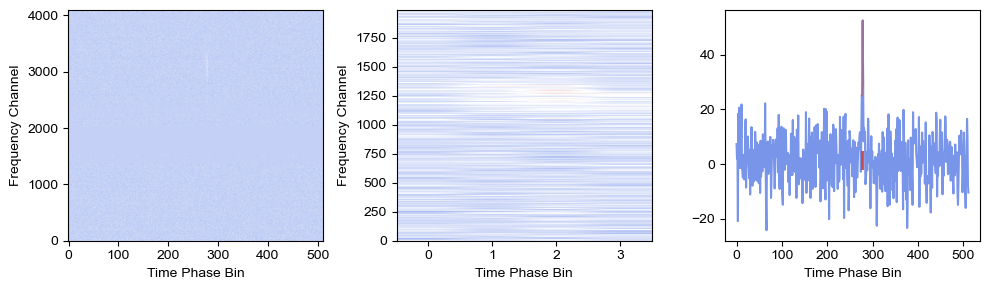

In [35]:
clist = ['royalblue', 'white', 'r']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(I, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(132)
plt.imshow(I_clean, aspect='auto', origin='lower', cmap=new_cmap)
plt.xlabel('Time Phase Bin')
plt.ylabel('Frequency Channel')

plt.subplot(133)
plt.plot(np.sum(I[signal_chan!=0], axis=0), color='royalblue', alpha=0.7)
plt.plot(np.arange(I.shape[1])[signal_time!=0], np.sum(I_clean, axis=0), color='r', alpha=0.5)
plt.vlines(np.where(signal_time!=0), -2, 5, color='r', alpha=0.7)
plt.xlabel('Time Phase Bin')

plt.tight_layout()
plt.show()

-393.39339339339335 -88.18181818181819


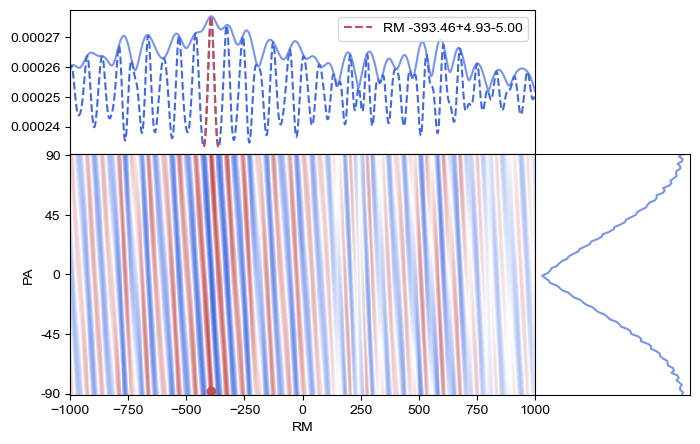

In [36]:
rm_num, rm_left, rm_right = 1000, -1000, 1000
RM = np.linspace(rm_left, rm_right, rm_num)
PAI = np.deg2rad(np.linspace(-90, 90, 100))
xx, yy = np.meshgrid(RM, PAI)

wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)
a = 1/np.sum((Qa/La-np.cos(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2 + \
           (Ua/La-np.sin(2 * yy[:,:,np.newaxis] + 2 * xx[:,:,np.newaxis] * wave**2))**2, axis=-1)

from scipy import interpolate
from matplotlib import gridspec

plt.figure(figsize=(8, 5))
gs = gridspec.GridSpec(8, 4)
plt.subplots_adjust(wspace=0, hspace=0)
clist = ['royalblue', 'white', 'r']
newcmp = LinearSegmentedColormap.from_list('wb', clist)

xindex = np.where(a==np.max(a))[0][0]
yindex = np.where(a==np.max(a))[1][0]
xindex_p = (xindex+50)%100
#xindex_p = xindex + 10
yindex_p = np.argmax(a[xindex_p])
corr_factor = np.abs(yindex_p - yindex)/np.sqrt((xindex_p - xindex)**2 + (yindex_p - yindex)**2)
print(xx[xindex][yindex], np.degrees(yy[xindex][yindex]))

plt.subplot(gs[0:3, 0:3])
plt.plot(RM, np.max(a, axis=0), color='royalblue', alpha=0.7)

# 局域最大值
plt.plot(RM, a[xindex], color='royalblue', ls='--')
asd = a[xindex]
intindex = (np.diff(np.sign(np.diff(asd))) > 0).nonzero()[0] + 1
intindex = intindex[np.abs(np.argmax(asd) - intindex)>5]
intindex = np.sort(intindex[np.argsort(np.abs(np.argmax(asd) - intindex))[:2]])
x = RM[intindex[0]: intindex[1]]
y = asd[intindex[0]: intindex[1]]
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.linspace(x.min(), x.max(), 500)
y_new = f(x_new)
rm_max = x_new[np.argmax(y_new)]
rm_error = -(x_new[np.argmax(y_new)] - x_new[y_new>(y_new.max()*(1-1/np.sqrt(np.e))+y_new.min()*(1/np.sqrt(np.e)))][[-1, 0]])*corr_factor
plt.plot(x_new, y_new, color='r', label='RM {:.2f}+{:.2f}{:.2f}'.format(rm_max, *rm_error), ls='--')
plt.legend()
plt.xticks([])
plt.xlim(rm_left, rm_right)

plt.subplot(gs[3:, 0:3])
pcm = plt.pcolormesh(xx, yy, a, cmap=new_cmap, shading='auto')
plt.scatter(xx[xindex][yindex], yy[xindex][yindex], color='r')
plt.xlim(rm_left, rm_right)
plt.yticks(np.deg2rad(np.linspace(-90, 90, 5)), np.linspace(-90, 90, 5).astype(np.int64))
plt.xlabel('RM')
plt.ylabel('PA')

plt.subplot(gs[3:, 3:])
plt.plot(np.max(a, axis=1), np.degrees(PAI), color='royalblue', alpha=0.7)
plt.xticks([])
plt.yticks([])
plt.ylim(-90, 90)
plt.show()

In [37]:
wave = const.c.value/freq_clean/1e6
Ia, Qa, Ua, Va = np.mean(I_clean, axis=1), np.mean(Q_clean, axis=1), np.mean(U_clean, axis=1), np.mean(V_clean, axis=1)
La = np.sqrt(Qa**2 + Ua**2)

def log_likelihood(par, wave, y1, y2):
    pa, rm = par
    p = 2*np.deg2rad(pa) + 2*rm*wave**2
    calul, calql = np.sin(p), np.cos(p)
    return -0.5 * np.sum((calul-y1)**2 + (calql-y2)**2)

def log_probability(par, wave, y1, y2):
    pa, rm = par
    if -90 < pa < 90 and -10000 < rm < 10000:
        lp =  0
    else:
        lp = -np.inf
    lk = log_likelihood(par, wave, y1, y2)
    if np.isnan(lk):
        return -np.inf
    return lp + lk

import emcee
from multiprocessing import Pool

ndim = 2
nwalkers = 10
p0 = np.zeros((nwalkers, ndim))
p0[:, 0] = np.random.rand(nwalkers)*10-90
p0[:, 1] = np.random.rand(nwalkers)*10-420

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=[wave, Ua/La, Qa/La])
pos = sampler.run_mcmc(p0, 3000, progress=True)
sampler.reset()
sampler.run_mcmc(pos, 1000, progress=True)

result = sampler.chain[:, :, :].reshape((-1, ndim))

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1194.72it/s]


In [38]:
# from matplotlib import gridspec
# clist = ['white', 'royalblue']
# new_cmap = LinearSegmentedColormap.from_list('wb', clist)
# 
# plt.figure(figsize=(6, 5))
# plt.subplots_adjust(wspace=0, hspace=0)
# gs = gridspec.GridSpec(6, 7)
# 
# print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
#                                                   result[:, 0].mean(), result[:, 0].std()))
# lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
# lowlim, uplim = np.diff(lim_value)
# samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})
# 
# g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True,
#                 label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
#                 cbar=True, cbar_kws={'label': 'Number Density'})
# print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
# plt.xlim(-100, -60)
# plt.ylim(-402, -390)
# 
# cbar_ticks = g.figure.axes[-1].get_yticks()
# _, cbar_max = g.figure.axes[-1].get_ylim()
# g.figure.axes[-1].set_yticks(cbar_ticks, ['5 %'] + ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks[1:]])
# ax = plt.gca()
# plt.text(0.05, 0.92, 'A', weight='bold', transform=ax.transAxes)
# g.set_xlabel('PA (degree)')
# g.set_ylabel('RM (rad/m$^2$)')
# 
# plt.savefig('Figure/190303-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
# plt.show()

RM: -395.7090258924678 +- 2.248243891898416,
PA: -81.55156851295963 +- 6.248660634948095
RM: -395+2-3


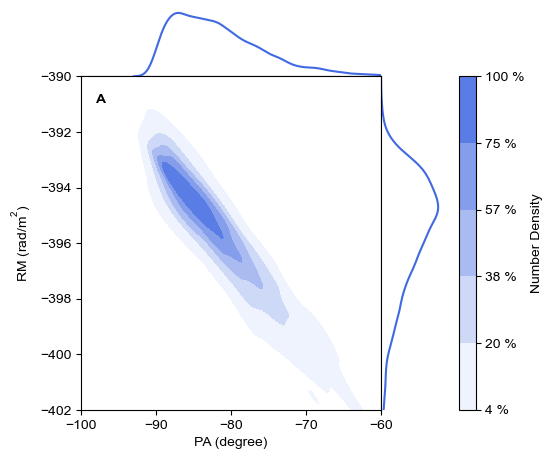

In [39]:
from matplotlib import gridspec
clist = ['white', 'royalblue']
new_cmap = LinearSegmentedColormap.from_list('wb', clist)

plt.figure(figsize=(6, 5))
plt.subplots_adjust(wspace=0, hspace=0)
gs = gridspec.GridSpec(6, 7)

print('RM: {} +- {},\nPA: {} +- {}'.format(result[:, 1].mean(), result[:, 1].std(),
                                                  result[:, 0].mean(), result[:, 0].std()))
lim_value = np.sort(result[:, 1])[[int(result.shape[0]*0.16), int(result.shape[0]*0.5), int(result.shape[0]*0.84)]]
lowlim, uplim = np.diff(lim_value)
samp_data = pd.DataFrame({'PA': result[:, 0], 'RM': result[:, 1]})

ax1 = plt.subplot(gs[0:1, 0:5])
# g = sns.histplot(data=samp_data, x='PA', color='royalblue', edgecolor='white', ax=ax1, stat='density', bins=np.linspace(-100, 20, 40))
g = sns.kdeplot(data=samp_data, x='PA', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, left=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.xlim(-100, -60)

ax1 = plt.subplot(gs[1:6, 0:5])
g = sns.kdeplot(data=samp_data, x='PA', y='RM', levels=6, cmap=new_cmap, fill=True, ax=ax1, 
                label='RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)),
                cbar=True, cbar_kws={'label': 'Number Density'})
print('RM: {:.0f}+{:.0f}-{:.0f}'.format(np.round(lim_value[1], 0), np.round(uplim, 0), np.round(lowlim, 0)))
plt.xlim(-100, -60)
plt.ylim(-402, -390)
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1)
pos_joint_ax = g.get_position()
g.set_position([pos_joint_ax.x0, pos_joint_ax.y0, 0.5, pos_joint_ax.height])
g.figure.axes[-1].set_position([.73, pos_joint_ax.y0, .07, pos_joint_ax.height])

cbar_ticks = g.figure.axes[-1].get_yticks()
_, cbar_max = g.figure.axes[-1].get_ylim()
g.figure.axes[-1].set_yticks(cbar_ticks, ['{} %'.format(np.int64(np.round(t/cbar_max*100, 0))) for t in cbar_ticks])
ax = plt.gca()
plt.text(0.05, 0.92, 'A', weight='bold', transform=ax.transAxes)
g.set_xlabel('PA (degree)')
g.set_ylabel('RM (rad/m$^2$)')

ax1 = plt.subplot(gs[1:6, 5:6])
g = sns.kdeplot(data=samp_data, y='RM', fill=False, ax=ax1, color='royalblue')
sns.despine(right=True, bottom=True, top=True, ax=ax1)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.ylim(-402, -390)

# plt.savefig('Figure/190303-MCMC.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

RM: -395.35361481187914, RM_Error: 14.238757409855403


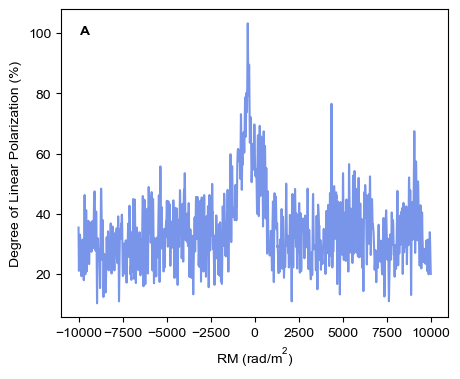

In [40]:
rm_num = 10000
Linear, rm_list = [], np.linspace(-10000, 10000, rm_num)
wave = const.c.value/freq_clean/1e6
wave = wave.reshape(-1, 1)
for RM in rm_list:
    PA = 2 * RM * wave**2
    Q_C = np.cos(PA)*Q_clean + np.sin(PA)*U_clean
    U_C = -np.sin(PA)*Q_clean + np.cos(PA)*U_clean
    Lsum = np.sum(np.sqrt(np.sum(Q_C, axis=0)**2 + np.sum(U_C, axis=0)**2))
    Linear = np.append(Linear, Lsum/np.sum(I_clean))
    
def rm_fit_func(x, a, b, c):
    return a * (x - b)**2 + c

rm_max_index = np.argmax(Linear)
fit_num = np.int64(len(rm_list[Linear>(np.max(Linear)+np.min(Linear))/4*3])/2)
x = rm_list[rm_max_index-fit_num: rm_max_index+fit_num]
y = Linear[rm_max_index-fit_num: rm_max_index+fit_num]
popt, pcov = curve_fit(rm_fit_func, x, y)
rm_max = popt[1]
rm_error = 2 * np.sqrt(-popt[2]/2/popt[0]) / snr
print('RM: {}, RM_Error: {}'.format(rm_max, rm_error))

plt.figure(figsize=(5, 4))
plt.plot(rm_list, Linear*100, color='royalblue', alpha=0.7, label='RM {:.0f}$\\pm${:.0f}'.format(np.round(rm_max, 0), np.round(rm_error, 0)))
plt.xlabel('RM (rad/m$^2$)')
plt.ylabel('Degree of Linear Polarization (%)')
ax = plt.gca()
plt.text(0.05, 0.92, 'A', weight='bold', transform=ax.transAxes)

# plt.savefig('Figure/190303-FDF.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
rm = rm_max
wave = const.c.value/freq/1e6
wave = wave.reshape(-1, 1)
PA = 2 * rm * wave**2
Q_C = np.cos(PA)*Q + np.sin(PA)*U
U_C = -np.sin(PA)*Q + np.cos(PA)*U
I, Q, U, V = I, Q_C, U_C, V

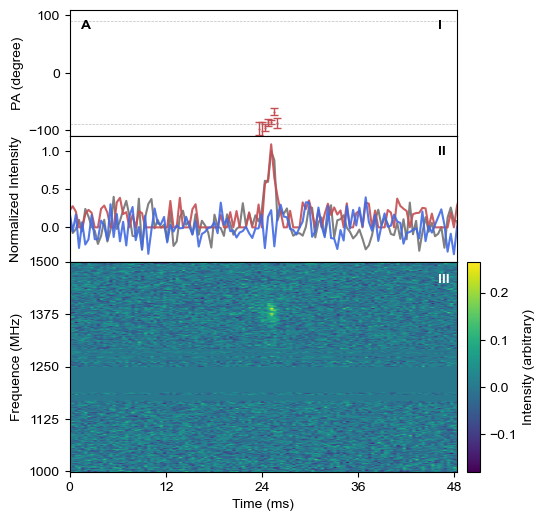

In [42]:
from matplotlib import gridspec
plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(11, 1)
plt.subplots_adjust(hspace=0)

pol1 = np.stack([I, Q, U, V])
max_index = np.argmax(np.sum(pol1[0], axis=0))
I, Q, U, V = pol1[:, :, max_index-64: max_index+64]
Ia, Qa, Ua, Va = np.mean(I, axis=0), np.mean(Q, axis=0), np.mean(U, axis=0), np.mean(V, axis=0)
freq_len, time_len = I.shape
I_new = np.mean(I.reshape(freq_len//16, 16, time_len), axis=1)
normfactor = np.mean(I, axis=0).max()

plt.subplot(gs[0:3, 0])

sigma_Q = Qa[:10].std()
sigma_U = Ua[:10].std()

PA = np.degrees(np.arctan2(Ua, Qa)/2)
PAE = np.degrees(np.sqrt((Qa**2 * sigma_U**2 + Ua**2 * sigma_Q**2)/(4 * (Qa**2 + Ua**2)**2)))
PAT = np.arange(len(PA)).astype(np.float64)

PA[:60] = np.nan
PA[67:] = np.nan
PAE[:60] = np.nan
PAE[67:] = np.nan

PA[60:63] += -180

plt.errorbar(PAT, PA, PAE, color='r', fmt='.', capsize=3, lw=1, ms=1)
plt.hlines(90, 0, 123, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.hlines(-90, 0, 123, ls='--', color='gray', alpha=0.5, lw=0.5)
plt.xticks([])
plt.xlim(0, 123)
plt.ylim(-110, 110)
plt.ylabel('PA (degree)', labelpad=3)
ax = plt.gca()
plt.text(0.03, 0.85, 'A', weight='bold', transform=ax.transAxes)
plt.text(0.95, 0.85, 'I', weight='bold', transform=ax.transAxes)

plt.subplot(gs[3:6, 0])
L = np.sqrt(np.mean(Q, axis=0)**2+np.mean(U, axis=0)**2)
rms = np.mean(I, axis=0)[:10].std()
L[L/rms <= 1.57] = 0
L[L/rms > 1.57] = np.sqrt(L[L/rms > 1.57]**2 - rms**2)
plt.plot(Ia/normfactor, color='gray')
plt.plot(L/normfactor, color='r', alpha=0.9)
plt.plot(Va/normfactor, color='royalblue', alpha=0.9)
plt.ylim(-0.45, 1.2)
plt.ylabel('Normalized Intensity', labelpad=13)
ax = plt.gca()
plt.text(0.95, 0.85, 'II', weight='bold', transform=ax.transAxes)
plt.xlim(0, 123)
plt.xticks([])

plt.subplot(gs[6:, 0])
plt.imshow(I_new, aspect='auto', cmap='viridis', origin='lower')
plt.xticks(np.linspace(0, 48, 5)*1e3/4/98.304, np.linspace(0, 48, 5).astype(np.int64))
plt.yticks(np.linspace(0, 256, 5).astype(np.int64), np.linspace(1000, 1500, 5).astype(np.int64))
plt.xlim(0, 123)
plt.xlabel('Time (ms)')
plt.ylabel('Frequence (MHz)')
ax = plt.gca()
plt.text(0.95, 0.9, 'III', weight='bold', color='white', transform=ax.transAxes)
plt.colorbar(cax=plt.axes([0.92, 0.11, 0.025, 0.35]), label='Intensity (arbitrary)')

# plt.savefig('Figure/190303-Spec.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()